## Decision Trees

Implement a decision tree algorithm from scratch using a binary splitting structure, taking the Gini Index as the loss.
\begin{align}
l = \sum_{k=1}^c \hat p_{mk}(1 - \hat p_{mk})
\end{align}
where $\hat p_{mk}$ is the empirical fraction of samples in some region $m$ of the space belonging to class $k$ out of $c$ total class labels, is general to the number of classes c.
- Allows for multiclass classification 
- The maximum depth of the decision tree can be controlled through a user-selected parameter
- Allows for Random Forest algorithm, and implements two feature subsampling methods, to randomly select from $m < p$ input features for determining the best split, for each split in the tree-building process. Allow for the user to select from $m=p$ (no subsampling), $m = p/2$, and $m=\sqrt{p}$ features.
- A stopping criterion uses reaching the maximum depth, pure leaf nodes, or a minimal number of samples

In [ ]:
import numpy as np

class DecisionNode:
    def __init__(self):
        self.label = None
        self.split_on = None
        self.trueNode = None
        self.falseNode = None     
        
def gini(ys, indices):
    n = len(indices)
    p = np.unique(ys[indices], return_counts=True)[1] / n
    gini = 0
    for pmk in p:
        gini += pmk * (1-pmk)
    return gini

# compute info content after splitting
def info_gain(ys, indices1, indices2):
    n1 = len(indices1)
    n2 = len(indices2)
    n = n1 + n2
    info_split = n1 / n * gini(ys, indices1) + n2 / n * gini(ys, indices2)
    return info_split

# return best feature to split on and the best value to split on
def best_split(xs, ys, indices, subsampling):
    m = xs.shape[1]
    # subsampling style
    match(subsampling):
        case 0:
            features = range(m)
        case 1:
            features = np.random.choice(range(m), size=int(m/2), replace=False)
        case 2:
            features = np.random.choice(range(m), size=int(np.sqrt(m)), replace=False)

    # pick best feature to split on
    best_feat_ig = np.ones(m) * float('inf')
    best_split = np.zeros(m)
    for c in features:
        # test each possible split for a given feature
        splits = np.unique(xs[indices][:, c])
        for k in splits:
            indices1 = [i for i in indices if xs[i][c] <= k]
            indices2 = np.setdiff1d(indices, indices1, assume_unique=True)
            gain = info_gain(ys, indices1, indices2)
            # if better info content
            if gain < best_feat_ig[c] :
                best_feat_ig[c] = gain
                best_split[c] = k
                
    feat = np.argmin(best_feat_ig)
    return feat, best_split[feat] 

# recursively classify 
def classify(tree, xs, i):
    if tree.label is None: # internal node
        if (xs[i][tree.split_on[0]]) <= tree.split_on[1]:
            return classify(tree.trueNode, xs, i)
        else:
            return classify(tree.falseNode, xs, i)
    else: # leaf node
        return tree.label
    
# recursively build decision tree
# indices keep track of what data points are at that node
# subsampling 0: p=m, 1: p = m/2, 2: p = sqrt(m)
def build_decision_tree(node, xs, ys, indices, max_depth=float('inf'), subsampling=0):
    labels, counts = np.unique(ys[indices], return_counts=True)
    # stopping criteria
    if max_depth == 0 or len(labels) == 1 or len(indices) <= 2:
        node.label = labels[np.argmax(counts)]        
        return
    # get best feature, value to split on
    feat, val = best_split(xs, ys, indices, subsampling)
    node.split_on = (feat, val)
    true_indices = [i for i in indices if xs[i][feat] <= val]
    false_indices = np.setdiff1d(indices, true_indices, assume_unique=True)
    # create left node and recurse
    trueNode = DecisionNode() 
    build_decision_tree(trueNode, xs, ys, true_indices, max_depth - 1, subsampling)
    node.trueNode = trueNode
    
    # create right node and recurse
    falseNode = DecisionNode() 
    build_decision_tree(falseNode, xs, ys, false_indices, max_depth - 1, subsampling)
    node.falseNode = falseNode
    return
    
    

Accuracy of Custom Decision Tree: 86.00%
Accuracy of Sklearn DecisionTreeClassifier: 92.00%


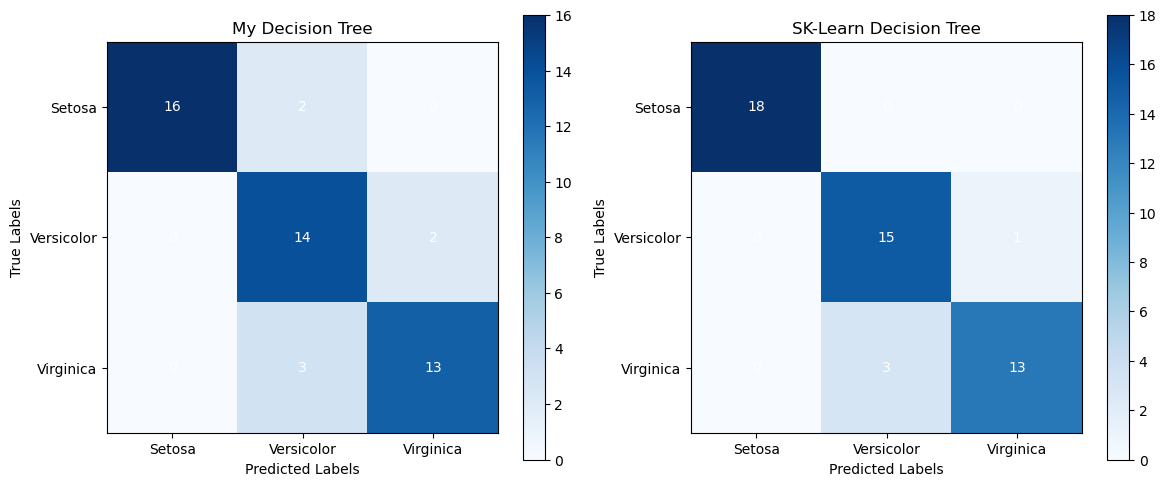

In [ ]:

import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

df = pd.read_csv("iris.csv").to_numpy()
n, m = df.shape

# split data
np.random.shuffle(df)
split_i = int(n * 0.67)
train = df[: split_i]
test = df[split_i : ]

train_xs =  train[:, :-1]
train_ys =  train[:, -1]

test_xs =  test[:, :-1]
test_ys =  test[:, -1]

# build my tree and make predictions
tree = DecisionNode()
build_decision_tree(tree, train_xs, train_ys, range(split_i), subsampling=2)
pred = [''] * (n - split_i)
for i in range(n-split_i):
    pred[i] = classify(tree, test_xs, i)

# build sklearn decision tree and make predictions
sk_tree = DecisionTreeClassifier(random_state=42)
sk_tree.fit(train_xs, train_ys)
sk_pred = sk_tree.predict(test_xs)

# compute confusion matrices
cm = confusion_matrix(test_ys, pred)
sk_cm = confusion_matrix(test_ys, sk_pred)

accuracy_custom = np.sum(pred == test_ys) / len(test_ys)
accuracy_sklearn = np.sum(sk_pred == test_ys) / len(test_ys)
print(f"Accuracy of Custom Decision Tree: {accuracy_custom * 100:.2f}%")
print(f"Accuracy of Sklearn DecisionTreeClassifier: {accuracy_sklearn * 100:.2f}%")

# Plot two confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Define class labels
classes = ['Setosa', 'Versicolor', 'Virginica']

# Plot the first confusion matrix (for model 1)
axes[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[0].set_title('My Decision Tree')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')
axes[0].set_xticks(np.arange(len(classes)))
axes[0].set_yticks(np.arange(len(classes)))
axes[0].set_xticklabels(classes)
axes[0].set_yticklabels(classes)

# Annotate the first confusion matrix
for i in range(len(classes)):
    for j in range(len(classes)):
        axes[0].text(j, i, cm[i, j], ha="center", va="center", color="white")
fig.colorbar(axes[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues))

# Plot the second confusion matrix (for model 2)
axes[1].imshow(sk_cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[1].set_title('SK-Learn Decision Tree')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')
axes[1].set_xticks(np.arange(len(classes)))
axes[1].set_yticks(np.arange(len(classes)))
axes[1].set_xticklabels(classes)
axes[1].set_yticklabels(classes)

# Annotate the second confusion matrix
for i in range(len(classes)):
    for j in range(len(classes)):
        axes[1].text(j, i, sk_cm[i, j], ha="center", va="center", color="white")

# Add color bar
fig.colorbar(axes[1].imshow(sk_cm, interpolation='nearest', cmap=plt.cm.Blues))

# Show the plot
plt.tight_layout()
plt.show()



My implementation appears to have performed a little bit worse on the test set. This might be because I did not implement an improvement check on each split. I also did not use feature selection, set a max-depth or prune the tree. All these aspects may have resulted in my model overfitting on the training data, so it performed worse on the testing data.

Run Random Forest on ```heart.csv``` dataset for number of trees = ```[1,2,5,10,20,50,100,200,500,1000]``` and each of the cases of $m = p$, $m = p/2$, and $m = \sqrt(p)$. The maximum depth for an individual tree is 5.

In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv('heart.csv')
df = pd.get_dummies(df, columns=['cp', 'restecg'])
df = df.to_numpy()
n, m = df.shape

# split data
np.random.shuffle(df)
split_i = int(n * 0.67)
train = df[: split_i]
test = df[split_i : ]

train_xs =  train[:, :-1]
train_ys =  train[:, -1]

test_xs =  test[:, :-1]
test_ys =  test[:, -1]

test_sz = n - split_i
num_trees = [1,2,5,10,20,50,100,200,500,1000]

test_error = np.zeros((3, len(num_trees)))
for p in range(3):
    print(p)
    nt = 0
    pred = np.zeros((test_sz, 2)) # for test data
    for k in range(1000):
        tree = DecisionNode()
        # get boostrap sample
        indices = np.random.choice(len(ys), size=len(ys), replace=True)
        xs = train_xs[indices]
        ys = train_ys[indices]
        
        build_decision_tree(tree, xs, ys, range(split_i), max_depth=5, subsampling=p)
        for j in range(test_sz): # get predictions for each data point
            pred[classify(tree, test_xs, j)] += 1
                
        # get majority vote
        if k == num_trees[nt] - 1:
            print(num_trees[nt])
            majority_pred = np.argmax(pred, axis=1)
            error = 0
            for i in range(test_sz):
                if test_ys[i] != majority_pred[i]:
                    error += 1
            test_error[p, nt] = error / test_sz
            print(error)
            nt += 1

plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(num_trees, test_error[i], label=f'Feature Subsampling: {subsampling[i]}')
plt.xlabel('Number of Trees')
plt.ylabel('Test Classification Error')
plt.title('Test Classification Error vs. Number of Trees')
plt.legend()
plt.grid(True)
plt.show()
